# Morphological tessellation

One of the main features of `momepy` is the ability to generate and analyse morphological tessellation (MT). One can imagine MT like Voronoi tessellation generated around building polygons instead of points. The similarity is not accidental - the core of MT is a Voronoi diagram generated by `scipy.spatial.Voronoi`. We'll explain key parts of tessellation and explore its application in the real world.

## Using exemplary data

In [1]:
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
buildings = gpd.read_file(momepy.datasets.get_path('bubenec'),
                          layer='buildings')

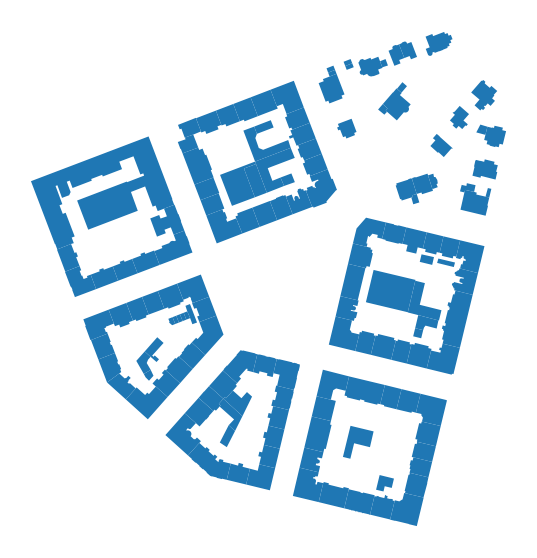

In [3]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax)
ax.set_axis_off()
plt.show()

To generate MT, each building needs to have an `unique_id` assigned, which will later link generated cell to its parent building. Exemplar `GeoDataFrame` comes with such ID in `uID` column.

In [4]:
buildings.head()

,uID,geometry
0,1,"POLYGON ((1603599.221 6464369.816, 1603602.984..."
1,2,"POLYGON ((1603042.880 6464261.498, 1603038.961..."
2,3,"POLYGON ((1603044.650 6464178.035, 1603049.192..."
3,4,"POLYGON ((1603036.557 6464141.467, 1603036.969..."
4,5,"POLYGON ((1603082.387 6464142.022, 1603081.574..."


As Voronoi tessellation tends to go to infinity for edge points, we have to define a limit for tessellation. It can be the area of your case study represented as a Polygon or MultiPolygon or you can use `momepy.buffered_limit` to generate such limit as a set maximal distance from buildings.

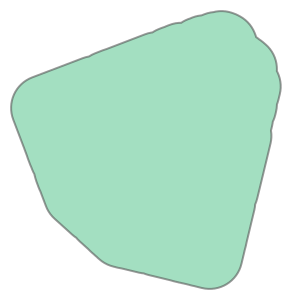

In [5]:
limit = momepy.buffered_limit(buildings, buffer=100)
limit

Other crucial attributes of tessellation algorithm are `segment` and `shrink`. Both are predefined as balanced values between the computational demands and a quality of a result. Segment defines the maximal distance between points generated to represent building footprint, shrink defines how much should be building buffered (inwards) to generate a gap between adjacent polygons. If you want to reduce memory requirements, you can use larger `segment` distance, but it may cause imprecision. 

In [6]:
tessellation = momepy.Tessellation(buildings, unique_id='uID', limit=limit)

  0%|          | 0/144 [00:00<?, ?it/s]

Inward offset...
Discretization...
Generating input point array...


100%|██████████| 144/144 [00:00<00:00, 314.86it/s]


Generating Voronoi diagram...


Vertices to Polygons:  11%|█         | 3565/32914 [00:00<00:00, 35641.45it/s]

Generating GeoDataFrame...


Vertices to Polygons: 100%|██████████| 32914/32914 [00:00<00:00, 33001.68it/s]


Dissolving Voronoi polygons...


 55%|█████▍    | 29/53 [00:00<00:00, 288.49it/s]

Preparing limit for edge resolving...
Building R-tree...
Identifying edge cells...


100%|██████████| 42/42 [00:00<00:00, 834.14it/s]


Cutting...


In [7]:
tessellation

GeoDataFrame containing the tessellation itself can be accessed using `tessellation` attribute. Similarly, used values and input geometry can be accessed using `shrink`, `segment`, `limit` of `gdf` attributes.

In [8]:
tessellation_gdf = tessellation.tessellation

In [9]:
tessellation.shrink

0.4

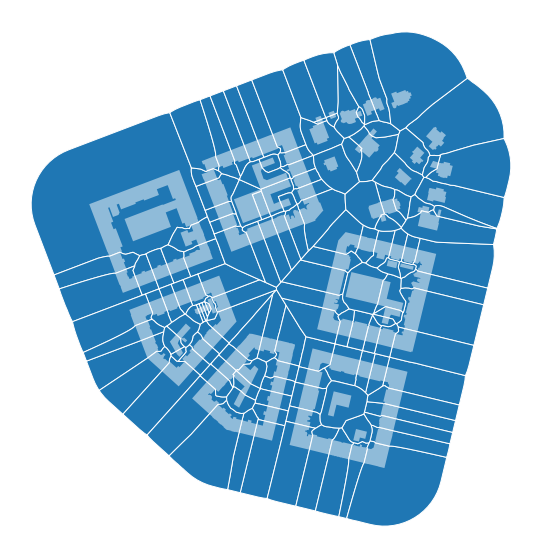

In [10]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation_gdf.plot(ax=ax, edgecolor='white')
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

Generated tessellation can be linked to buildings using `unique_id`, being the common column between both `GeoDataFrames`.

In [11]:
tessellation_gdf.head()

,uID,geometry
0,1,"POLYGON ((1603586.677 6464344.668, 1603578.491..."
1,2,"POLYGON ((1603048.399 6464176.181, 1603047.831..."
2,3,"POLYGON ((1603071.343 6464158.863, 1603071.179..."
3,4,"POLYGON ((1603055.834 6464093.615, 1602963.025..."
4,5,"POLYGON ((1603106.418 6464130.216, 1603112.191..."


## Generating tessellation based on OpenStreetmap

To illustrate a more real-life example, let's try to generate tessellation based on a small town retrieved from OSM. We will use `osmnx` package to get the data.

In [12]:
import osmnx as ox

gdf = ox.footprints.footprints_from_place(place='Kahla, Germany')
gdf_projected = ox.project_gdf(gdf)

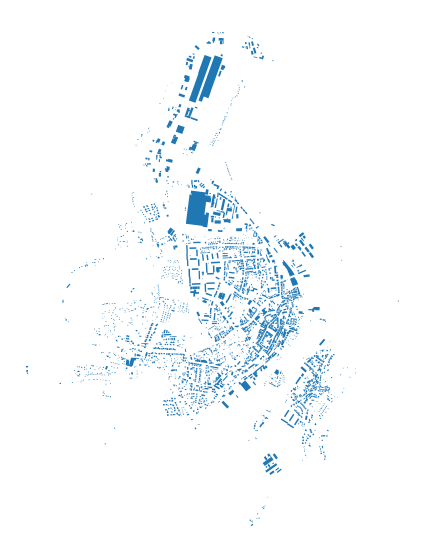

In [13]:
f, ax = plt.subplots(figsize=(10, 10))
gdf_projected.plot(ax=ax)
ax.set_axis_off()
plt.show()

While working with real-life data, we often face issues with their quality. To avoid some of the possible errors, we should preprocess (clean) the data. It is often done semi-manually within the GIS environment. `momepy` offers (experimental) `momepy.preprocess` to handle some of the expected issues. 

In [14]:
buildings = momepy.preprocess(gdf_projected, size=30,
                              compactness=True, islands=True)

Loop 1 out of 2.


Changing geometry: 100%|██████████| 31/31 [00:00<00:00, 87.32it/s]


Loop 2 out of 2.


Changing geometry: 100%|██████████| 2/2 [00:00<00:00, 41.79it/s]


What has happened? 
1. All auxiliary buildings (smaller than 30 square meters defined in `size`) were dropped.
2. Possible adjacent structures of specific circular compactness values (long and narrow) were joined to their parental buildings.
3. All buildings fully within other buildings (share 100% of the exterior boundary) were joined to their parental buildings.

Tessellation requires two other arguments: unique ID and limit. We will generate unique ID using `momepy.unique_id` and limit of tessellation using the same buffer method as above.

In [15]:
buildings['uID'] = momepy.unique_id(buildings)
limit = momepy.buffered_limit(buildings)

At this moment, we have everything we need to generate morphological tessellation. It might take a while for larger `GeoDataFrames`.

In [16]:
tessellation = momepy.Tessellation(buildings, unique_id='uID', limit=limit)
tessellation_gdf = tessellation.tessellation

Inward offset...
Discretization...


  2%|▏         | 61/2521 [00:00<00:08, 279.36it/s]

Generating input point array...


100%|██████████| 2521/2521 [00:04<00:00, 534.76it/s]


Generating Voronoi diagram...
Generating GeoDataFrame...


Vertices to Polygons: 100%|██████████| 267595/267595 [00:07<00:00, 37001.56it/s]


Dissolving Voronoi polygons...
Preparing limit for edge resolving...
Building R-tree...


  8%|▊         | 28/371 [00:00<00:01, 278.76it/s]

Identifying edge cells...


 21%|██        | 50/238 [00:00<00:00, 497.15it/s]

Cutting...


100%|██████████| 238/238 [00:00<00:00, 462.72it/s]


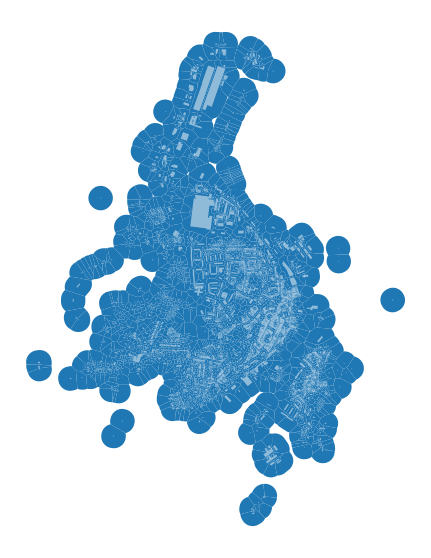

In [17]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation_gdf.plot(ax=ax)
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

Zooming closer to check the result:

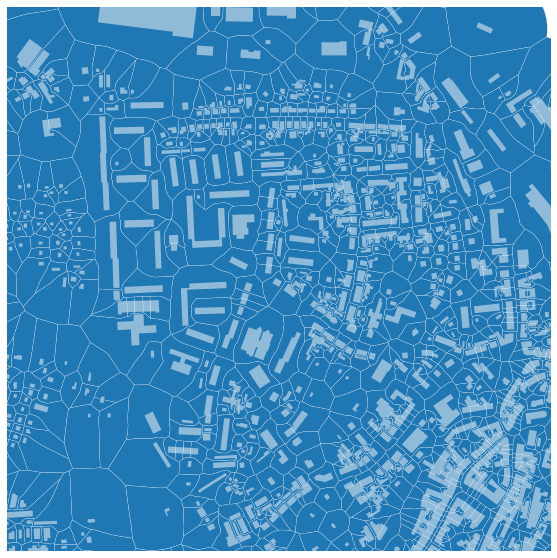

In [18]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation_gdf.plot(ax=ax, edgecolor='white', linewidth=0.2)
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
ax.set_xlim(681500, 682500)
ax.set_ylim(5631000, 5632000)
plt.show()

And we are done. Morphological tessellation is generated and ready for any further analysis.

### Troubleshooting

In some cases, `momepy.tessellation` raises errors or warnings. In 99% of cases, this is due to errors in input data. Two types of warnings are possible:

- `Tessellation does not fully match buildings. 10 element(s) collapsed "during generation - unique_id: [list of ids]`

In this case, some of the building shapes collapsed during the shrinkage. It should not happen as shrink distance is usually quite small, but you might be able to resolve it by setting smaller `shrink` distance. However, we would recommend fixing the data manually.


- `Tessellation contains MultiPolygon elements. Initial objects should be edited. unique_id of affected elements: [list of ids]`

This is a more common issue, which is again caused by imprecise data. Often caused by long and extremely narrow shapes or overlap of buildings. While some of the analysis might work even with MultiPolygon geometry, it does not really make sense, so we would recommend fixing the data beforehand.

However, for most of the data of higher quality, you should not see any of these warnings.